In [ ]:
"""
adiabatic kinetics simulation with sensitivity analysis
"""
import sys
import numpy as np
import pandas as pd
import cantera as ct
import matplotlib.pyplot as plt
import timeit

def ign_uq(g, factor, temp, pres, fuel, phi, T_equi, simtype='UV', bootplot=False):
	gas.set_multiplier(1.0) # reset all multipliers
	for i in range(gas.n_reactions):
		gas.set_multiplier(factor[i],i)
		# print(gas.reaction_equation(i)+' index_reaction:',i,'multi_factor:',factor[i])
	
	gas.set_equivalence_ratio( phi, fuel, 'O2:1.0, N2:3.76' )
	gas.TP = temp, pres*ct.one_atm

	# here it is constant volume with IdealGasReactor
	if simtype == 'UV':
		r = ct.IdealGasReactor(gas)
	else:
		r = ct.IdealGasConstPressureReactor(gas)

	sim = ct.ReactorNet([r])
	
	# set the tolerances for the solution and for the sensitivity coefficients
	sim.rtol = 1.0e-6
	sim.atol = 1.0e-15

	t_end = 10;
	time = []
	temp = []
	states = ct.SolutionArray(gas, extra=['t'])

	# stateArray = []
	while sim.time < t_end and r.T < T_equi - 0.1:
		sim.step()
		time.append(sim.time)
		temp.append(r.T)
		states.append(r.thermo.state, t=sim.time)
		# stateArray.append(r.thermo.X)

	time = np.array(time)
	temp = np.array(temp)
	diff_temp = np.diff(temp)/np.diff(time)

	if 0:
		# print(r.T, T_equi)
		plt.figure()
		plt.plot(states.t, states.T, '-ok')

		# plt.plot( 1.0, states.T[ign_pos], 'rs',markersize=6  )
		plt.xlabel('Time [ms]')
		plt.ylabel('T [K]')
		# plt.xlim( 0.99, 1.01 )
		#plt.ylim( -0.001,0.001 )
		plt.tight_layout()
		plt.show()

	ign_pos = np.argmax( diff_temp )

	ign = time[ign_pos]
	
	gas.set_multiplier(1.0) # reset all multipliers

	return ign

def ign_sens(g, temp, pres, fuel, phi, ign0, simtype='UV', bootplot=False):
	'''
	ign_sens(g, temp, pres, fuel, phi, ign0, simtype='UV', bootplot=False)
	'''
	gas.set_multiplier(1.0) # reset all multipliers

	gas.set_equivalence_ratio( phi, fuel, 'O2:1.0, N2:3.76' )
	gas.TP = temp, pres*ct.one_atm

	# here it is constant volume with IdealGasReactor
	if simtype == 'UV':
		r = ct.IdealGasReactor(gas)
	else:
		r = ct.IdealGasConstPressureReactor(gas)

	sim = ct.ReactorNet([r])
	for i in range(gas.n_reactions):
		r.add_sensitivity_reaction(i)

	# set the tolerances for the solution and for the sensitivity coefficients
	sim.rtol = 1.0e-6
	sim.atol = 1.0e-15
	sim.rtol_sensitivity = 1.0e-6
	sim.atol_sensitivity = 1.0e-6
	sens_T = []
	states = ct.SolutionArray(gas, extra=['t'])

	t_end = 10;
	time = []
	temp = []
	# stateArray = []
	while sim.time < ign0*1.5:
		sim.step()
		sens_T.append( sim.sensitivities()[2,:] )
		states.append(r.thermo.state, t=sim.time)
		time.append( sim.time )
		temp.append( r.T )

	time = np.array(time)
	temp = np.array(temp)
	diff_temp = np.diff(temp)/np.diff(time)
	sens_T = np.array( sens_T )

	ign_pos = np.argmax( diff_temp )
	ign = time[ign_pos]
	
	if bootplot:
		plt.figure()
		plt.plot(states.t/ign0, states.T, '-ok')

		plt.plot( 1.0, states.T[ign_pos], 'rs',markersize=6  )
		plt.xlabel('Time [ms]')
		plt.ylabel('T [K]')
		plt.xlim( 0.99, 1.01 )
		#plt.ylim( -0.001,0.001 )
		plt.tight_layout()
		plt.show()

	sens_T_ign = sens_T[ign_pos, :]
	return sens_T_ign

CH4_gri30.xml_0.5_20_1000.0_0.05_UV
Ignition Delay is: 34.8857 ms
Start Adjoint


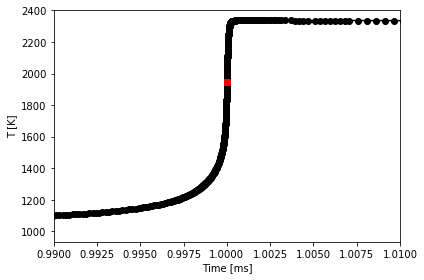

Finish Adjoint 27.15
Start Brute Force
Finish Brute Force 35.23 [s]
14 4.45180845443
22 11.6854922906


In [2]:
pres = 20
temp = 1000.0
phi = .5
simtype = 'UV'

fuel = 'CH4'
mech = 'gri30.xml'
dk = 5.e-2

# mech = 'h2_li_19.xml'
# fuel = 'nc7h16'
# mech = 'nc7sk88.cti'
# gas = ct.Solution('mech/dme_sk39.cti')
# gas = ct.Solution('mech/ic8sk143.cti')
# mech = "c4_49.xml"

string_list = [fuel, mech, str(phi), str(pres), str(temp), str(dk), simtype]
string_list = '_'.join(string_list)
print(string_list)


mechfile = 'mech/'+mech
gas = ct.Solution(mechfile)
gas.set_equivalence_ratio( phi, fuel, 'O2:1.0, N2:3.76' )
gas.TP = temp, pres*ct.one_atm

# print('species_names:')
# print(gas.species_names)
# print(gas.species_index('OH'))

# Get equilibrium temperature for ignition break
gas.equilibrate(simtype)
T_equi = gas.T

m = gas.n_reactions

# Create a dataframe to store sensitivity-analysis data
ds = pd.DataFrame(data=[], index=gas.reaction_equations(range(m)))
pd.options.display.float_format = '{:,.2e}'.format

# Create an empty column to store the sensitivities data. 
# baseCase for brute force method
ds["index"] = ""
ds["bruteforce"] = ""
ds["adjoint"] = ""
ds["ratio"] = ""

# base case
factor = np.ones( gas.n_reactions )
ign0 = ign_uq(gas, factor, temp, pres, fuel, phi, T_equi, simtype, False)
print("Ignition Delay is: {:.4f} ms".format(ign0*1000))


start_time = timeit.default_timer()
print('Start Adjoint')

sens_T_ign = ign_sens(gas, temp, pres, fuel, phi, ign0, simtype, True)

elapsed = timeit.default_timer() - start_time
print('Finish Adjoint {:.2f}'.format(elapsed))


factor = np.ones( ( gas.n_reactions, 1 ) )

start_time = timeit.default_timer()
print('Start Brute Force')

for i in range(m):
    factor[i] = 1+dk
    ign = ign_uq(gas, factor, temp, pres, fuel, phi, T_equi, simtype, False)
    factor[i] = 1.0
    ds["bruteforce"][i] = (ign-ign0)/(ign0*dk)

elapsed = timeit.default_timer() - start_time
print('Finish Brute Force {:.2f} [s]'.format(elapsed))

for i in range(m):
    ds['index'][i] = i
    ds["adjoint"][i] = -sens_T_ign[i]
    ds["ratio"][i] = ds["bruteforce"][i] /(ds["adjoint"][i] + 1.E-30)

ds['adjointabs'] = ds['adjoint'].abs()
ds = ds.sort_values( by=["adjointabs"] ,ascending=False)
# print( ds.to_string(index=True) )


index = ds['adjoint'].abs() > 0.05*ds['adjoint'].abs().max()
rxn1 = sum(index)
error1 = (ds[index]['ratio'].max() - ds[index]['ratio'].min())/ds[index]['ratio'].max()*100
print( sum(index) ,error1 )

index = ds['adjoint'].abs() > 0.01*ds['adjoint'].abs().max()
rxn2 = sum(index)
error2 = (ds[index]['ratio'].max() - ds[index]['ratio'].min())/ds[index]['ratio'].max()*100
print( sum(index) ,error2 )

ubf = ds['bruteforce']/np.linalg.norm(ds['bruteforce'])
uad = ds['adjoint']/np.linalg.norm(ds['adjoint'])
results_df = pd.DataFrame(data = {"maxerror_0.1":[error1, rxn1],"maxerror_0.01":[error2, rxn2], "ign0|cos":[ign0, np.dot(ubf.values, uad.values)]})

In [3]:
print(ds)

                             index bruteforce   adjoint     ratio adjointabs
CH3 + HO2 <=> CH3O + OH        118  -6.26e-01 -2.05e+03  3.05e-04   2.05e+03
2 CH3 (+M) <=> C2H6 (+M)       157   5.18e-01  1.64e+03  3.17e-04   1.64e+03
CH2O + O2 <=> HCO + HO2         31  -3.48e-01 -1.12e+03  3.11e-04   1.12e+03
CH3 + O2 <=> CH2O + OH         155  -2.45e-01 -7.81e+02  3.13e-04   7.81e+02
2 HO2 <=> H2O2 + O2            115   2.34e-01  7.38e+02  3.17e-04   7.38e+02
CH3 + O2 <=> CH3O + O          154  -1.95e-01 -6.17e+02  3.16e-04   6.17e+02
CH2O + HO2 <=> H2O2 + HCO      120  -1.35e-01 -4.32e+02  3.13e-04   4.32e+02
2 OH (+M) <=> H2O2 (+M)         84  -1.08e-01 -3.53e+02  3.06e-04   3.53e+02
CH2O + CH3 <=> CH4 + HCO       160  -9.79e-02 -3.11e+02  3.15e-04   3.11e+02
CH2O + OH <=> H2O + HCO        100  -7.26e-02 -2.32e+02  3.13e-04   2.32e+02
CH4 + OH <=> CH3 + H2O          97   6.44e-02  2.07e+02  3.11e-04   2.07e+02
2 HO2 <=> H2O2 + O2            114   6.49e-02  2.04e+02  3.19e-04   2.04e+02